In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import betaln
from jax.scipy.special import gammaln
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
from numpy.random import gamma
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp
from scipy.stats import bernoulli

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=bcd03aeefdec10255c69b866c98f3d88938c6f5e26681a56961a1e05cff1f222
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [2]:
seed = 2022
key = random.PRNGKey(seed)

n = 1000
d = 2

In [3]:
# n of cluster and pi generation
k = 50

alpha = 5.0 #bigger alpha, more clusters
vi = beta.rvs(alpha, 1, size = k)

pi = np.cumprod(vi)

In [4]:
# Z generation

Z = np.zeros((n,k))

for i in range(0, n):
  for j in range(0, k):
    Z[i,j] = bernoulli.rvs(pi[j])

In [5]:
# A generation

A = np.zeros((k,d))
sigma2a = 1.0
Id = np.eye(d)
mu0 = np.zeros(d)

for i in range(0, k):
  A[i] = mvn(mu0, sigma2a*Id)

In [11]:
# Finally X
X=np.zeros((n,d))
sigma2x=1.0
for i in range(n):
  X[i,:] = mvn(jnp.matmul(Z[i,:],A),sigma2x*Id)

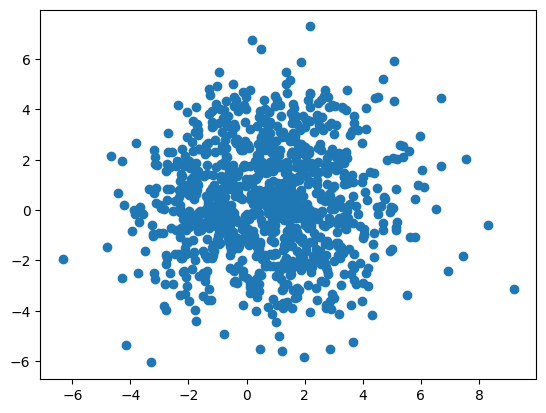

In [12]:
x = X[:,0]
y = X[:,1]

plt.scatter(x, y)
plt.show()

In [ ]:
def compute_ELBO(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha):
  K=phi_means.shape[0]
  d=data.shape[1]
  N=data.shape[0]
  T1=jnp.sum(betaln(tau[:,0],tau[:,1]))+jnp.sum(-(tau[:,0]-1)*digamma(tau[:,0])-(tau[:,1]-1)*digamma(tau[:,1])+(tau[:,0]+tau[:,1]-2)*digamma(tau[:,0]+tau[:,1]))
  T1+= d/2*jnp.sum(jnp.log(jnp.linalg.det(phi_variances))) # da adattare in base a come rappresentiamo phi_variances
  T1+= jnp.sum(-nu*jnp.log2(nu)-(1-nu)*jnp.log2(1-nu))

  T2=(alpha/K-1)*jnp.sum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))

  T3 = -0.5/sigma2a*(jnp.sum(jnp.sum(jnp.diag(phi_variances[???]))) + jnp.sum(jnp.diag(phi_means @ phi.means.T))) # il primo elemento è la traccia di phi_variances di k

  T4 = jnp.sum( nu @ (digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1])) + (1-nu) @ (digamma(tau[:,1])-digamma(tau[:,0]+tau[:,1])))

  traces= ??? # vector for traces of phi_variances,it is convenient to do it before and use it afterwards
  T5 = -0.5/sigma2x*(-2*jnp.sum(jnp.diag((nu @ phi_means) @ data.T))+ jnp.sum(nu @ (traces + jnp.diag(phi_means @ phi_means.T)))

In [ ]:
def single_iteration_VI(data,K,i,nMax,tol,sigma2a,sigma2x,alpha):

  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  # random initialization of the variational parameters
  phi_means==random.normal(key,shape=(K,d))*jnp.sqrt(sigma2a)
  phi_variances= # dobbiamo pensare a come inizializarlo
  tau=jnp.array(random.geometric(key,0.25,(K,2)), dtype=float)
  nu=random.uniform(key,shape=(N,K))
  improvement=1
  ELBO_new=compute_ELBO_jit()
  ELBO_old=ELBO_new-1
  nit=0

  # codition funztion for the while loop
  def cond(state):
    _,_,_,_,_,_,_,nit,ELBO,improvement,tol,nMax=state
    return (((improvement>tol) & (nit<nMax)))

  # body function for the while loop
  def iteration_while(state):
    data,gamma,tau1,tau2,phi,a_t,b_t,nit,ELBO_new,improvement,tol,nMax=state
    # update of variational parameters
    phi_means,phi_variances=update_phi_jit()
    tau=update_tau_jit()
    nu=update_nu()
    # we resize tau2 this way for matrix multiplications
    ELBO_old=ELBO_new
    # computation of ELBO and imporvement
    ELBO_new=compute_ELBO_jit()
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,gamma,tau1,tau2,phi,a_t,b_t,nit,ELBO_new,improvement,tol,nMax)

  state=(data,gamma,tau1,tau2,phi,a_t,b_t,nit,ELBO_new,improvement,tol,nMax)
  _,gamma,tau1,tau2,phi,a_t,b_t,nit,ELBO_new,improvement,_,_=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)
  tau=[tau1,tau2]

  return  gamma,tau,phi,a_t,b_t,ELBO_new,nit

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['T'])

In [ ]:
def VI(data,K,nMax,n_iniz,tol,sigma2a,sigma2x,alpha):
  ELBO_max=0
  for i in range(n_iniz):
    # every iteration we call the algorithm function, then if the ELBO is better than the one before we save it, otherwise we simply go on
    tau,phi_means,phi_variances,nu,ELBO_new,nit=single_iteration_VI_jit(data,T,i,nMax,tol,sigma,alpha,a,b)
    if i==0:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return tau,phi_means,phi_variances,nu
